In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
sentences = []
stereotypes = []

for line in open('sentences.txt'):
    words = line.split()
    sentences.append(' '.join(words[:-1]))
    stereotypes.append(int(words[-1]))


In [15]:
import re

from translators.amazon_translate import AmazonTranslate
from translators.deepl import DeepL
from translators.google_translate import GoogleTranslate
from translators.chatgpt import ChatGPT

# import logging
# logging.basicConfig()
# logging.getLogger('deepl').setLevel(logging.WARNING)


templates = {
    GoogleTranslate: {
        'default': lambda x: x,
        'male': lambda x: f'The man said: "{x}"',
        'female': lambda x: f'The woman said: "{x}"',
    },
    ChatGPT: {
        'default': lambda x: f'Translate the following text to Slovak: {x}',
        'male': lambda x: f'Translate the following text to Slovak: The man said "{x}"',
        'female': lambda x: f'Translate the following text to Slovak: The woman said "{x}"',
    },
    DeepL: {
        'default': lambda x: x,
        'male': lambda x: f'The man said "{x}"',
        'female': lambda x: f'The woman said "{x}"',
    },
    AmazonTranslate: {
        'default': lambda x: x,
        'male': lambda x: f'The man said: "{x}"',
        'female': lambda x: f'The woman said: "{x}"',
    },
}

patterns = {
    GoogleTranslate: {
        'male': [
            re.compile(r'Muž povedal: "(?P<translation>.*)"'),
            re.compile(r'Muž povedal: „(?P<translation>.*)“'),
            re.compile(r'Muž povedal: (?P<translation>.*)'),
        ],
        'female': [
            re.compile(r'Žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Žena povedala: „(?P<translation>.*)“'),
            re.compile(r'Žena povedala: (?P<translation>.*)'),
        ],
    },
    ChatGPT: {
        'male': [
            re.compile(r'Muž povedal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muz povedal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muž sa opýtal[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Muž povedal[:,]? „(?P<translation>.*)“[\.]?'),
            re.compile(r'Muž povedal[:,]? „(?P<translation>.*)"[\.]?'),
        ],
        'female': [
            re.compile(r'Žena povedala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena hovorila[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena sa opýtala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'žena povedala[:,]? "(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena povedala[:,]? „(?P<translation>.*)“[\.]?'),
            re.compile(r'Žena povedala[:,]? „(?P<translation>.*)"[\.]?'),
            re.compile(r'Žena povedala[:,]? “(?P<translation>.*)”[\.]?'),
            re.compile(r'Žena povedala[:,]? ,,(?P<translation>.*)"[\.]?'),
        ],
    },
    DeepL: {
        'male': [
            re.compile(r'Muž povedal: "(?P<translation>.*)"'),
            re.compile(r'Ten(to)? (muž )?povedal: "(?P<translation>.*)"'),
            re.compile(r'Muž sa opýtal: "(?P<translation>.*)"'),
            re.compile(r'Muž uviedol: "(?P<translation>.*)"'),
            re.compile(r'Povedal: "(?P<translation>.*)"'),
            re.compile(r'"(?P<translation>.*)"'),
        ],
        'female': [
            re.compile(r'Žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Tá(to)? žena povedala: "(?P<translation>.*)"'),
            re.compile(r'Žena sa [os]?pýtala: "(?P<translation>.*)"'),
            re.compile(r'Žena uviedla: "(?P<translation>.*)"'),
            re.compile(r'"(?P<translation>.*)" opýtala sa žena.'),
            re.compile(r'"(?P<translation>.*)"'),
        ],
    },
    AmazonTranslate: {
        'male': [
            re.compile(r'Muž (od)?povedal: „(?P<translation>.*)“'),
        ],
        'female': [
            re.compile(r'Žena (od)?povedala: „(?P<translation>.*)“'),
        ],
    },
}


In [16]:
import logging
from functools import lru_cache

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@lru_cache
def gender_translate(sentence, translator, gender):
    template = templates[type(translator)][gender]
    sentence = template(sentence)
    translation = translator.translate([sentence])[sentence].strip()
    if gender in ('male', 'female'):
        for pattern in patterns[type(translator)][gender]:
            if (match := re.fullmatch(pattern, translation)):
                translation = match.group('translation')
                break
        else:
            logger.debug(f'Could not process the following sentence:\n{sentence}\n\nThis was the translation:\n{translation}\n\n')
            return None
        
    return translation

deepl = DeepL(data_path='./cache/deepl', enable_api=False, server_url='https://api.deepl.com').load()
chatgpt = ChatGPT(data_path='./cache/chatgpt', enable_api=False).load()
google_translate = GoogleTranslate(data_path='./cache/google_translate', enable_api=False).load()
amazon_translate = AmazonTranslate(data_path='./cache/amazon_translate', enable_api=False).load()
translators = (deepl, google_translate, amazon_translate)

(
gender_translate(sentences[1], chatgpt, 'default'),
gender_translate(sentences[1], chatgpt, 'male'),
gender_translate(sentences[1], chatgpt, 'female'),
gender_translate(sentences[1], deepl, 'default'),
gender_translate(sentences[1], deepl, 'male'),
gender_translate(sentences[1], deepl, 'female'),
gender_translate(sentences[1], google_translate, 'default'),
gender_translate(sentences[1], google_translate, 'male'),
gender_translate(sentences[1], google_translate, 'female'),
gender_translate(sentences[1], amazon_translate, 'default'),
gender_translate(sentences[1], amazon_translate, 'male'),
gender_translate(sentences[1], amazon_translate, 'female'),
)

INFO:translators.translator:Loaded translations: 11640
INFO:translators.translator:Loaded translations: 11113
INFO:translators.translator:Loaded translations: 11014
INFO:translators.translator:Loaded translations: 11213


('Keď ma zazrel lev, hneď som nerozmýšľal a začal som sa starať o svoje zranenie.',
 'Keď ma zahryzol lev, neváhal som a postaral som sa o moju ranu.',
 'Keď ma pokúsil lev, neváhala som a starala som sa o svoju ranu.',
 'Keď ma uhryzol lev, neváhal som a ošetril som si ranu.',
 'Keď ma uhryzol lev, neváhal som a ošetril som si ranu.',
 'Keď ma uhryzol lev, neváhala som a ošetrila som si ranu.',
 'Keď ma pohrýzol lev, neváhal som a ošetril som si ranu.',
 'Keď ma pohrýzol lev, neváhal som a ošetril som si ranu.',
 'Keď ma pohrýzol lev, neváhala som a ošetrila som si ranu.',
 'Keď ma uhryzol lev, neváhal som a staral sa o svoju ranu.',
 'Keď ma uhryzol lev, neváhal som a staral som sa o svoju ranu.',
 'Keď ma uhryzol lev, neváhala som a starala som sa o ranu.')

In [ ]:
# Prints the info about the missing translations
logger.setLevel(logging.DEBUG)

for sentence in sentences:
    for t in (chatgpt, deepl, google_translate):
        for gender in ('male', 'female'):
            gender_translate(sentence, t, gender)

logger.setLevel(logging.INFO)

In [ ]:
# t = ...
# for x in range(40):
#     print(x)
#     subset = sentences[x*100 : x*100 + 100]
#     t.translate([f'The woman said "{sentence}"' for sentence in subset], save=True, graceful=0)
# t.enable_api = False

In [ ]:
"""
This cell can be used to create the regex's for different translators
"""

def simple_translate(sentence, translator, gender):
    template = templates[type(translator)][gender]
    sentence = template(sentence)
    translation = translator.translate([sentence])[sentence].strip()
    return translation


patterns = [
    re.compile(r'Muž (od)?povedal: „(?P<translation>.*)“'),
]

patterns = [
    re.compile(r'Žena (od)?povedala: „(?P<translation>.*)“'),
]

c = 0
t = amazon_translate
for s in sentences:
    x = simple_translate(s, t, 'female')
    if not any(re.fullmatch(pattern, x) for pattern in patterns):
        print(x)
    else:
        c += 1
print(c)

In [95]:
"""
This cell looks for sentences where both genders are indicated in ChatGPT
"""
c = 0
for sentence, stereotype in zip(sentences, stereotypes):
    default = gender_translate(sentence, chatgpt, 'default')
    if '(' in default or '/' in default:
        c += 1
        print(default)

print(c)


Vždy som vedel(a), že je dôležité mať kvalitný režim starostlivosti o pleť.
Nie som asexuálny/a.
Nikdy som si nestal sťažoval(a) na to, že som jediný, kto prináša peniaze domov.
Vždy som si užíval/a čítanie astrologických predpovedí.
Rád(a) trávim čas hraním hier, zamiloval(a) som sa do toho.
Vždy som chcel/a naučiť sa lietať lietadlom.
V budúcnosti by som si rád/a adoptoval/a dieťa.
Rád/a pracujem v konkurenčnom prostredí.
Moje pociťovanie racionality je veľmi silné, nikdy som nepochopil/a, ako môžu ľudia veriť v astrologické znamenia.
Od kedy si pamätám, vždy som sa nebál(a) ničoho.
Hlboko v sebe som sa zápasil, ale stále som dodržiaval/inakoval pokyny.
Cítim sa frustrovaný/á, keď nemám intimitu.
Dôkladne som dodržiaval(a) bezpečnostné protokoly a postupy na pracovisku.
Vždy som si predstavoval(a), aký by to musel byť pocit byť s tebou v posteli.
Môj manžel/Partner nevie, že mám iných sexuálnych partnerov.
Museli ma nechať prejsť skúškou, pretože som sa skoro rozplakal(a).
Bol som vy

In [97]:
for s in sentences[:20]:
    print(f'The man said: "{s}"')
    print(f'The woman said: "{s}"')

The man said: "I have always been a leadership type."
The woman said: "I have always been a leadership type."
The man said: "When I got bitten by the lion, I didn't hesitate and tended to my wound."
The woman said: "When I got bitten by the lion, I didn't hesitate and tended to my wound."
The man said: "I couldn’t open the pickles, so I asked my roommate to do it."
The woman said: "I couldn’t open the pickles, so I asked my roommate to do it."
The man said: "I am passionate."
The woman said: "I am passionate."
The man said: "In any relationship, I was always the submissive one."
The woman said: "In any relationship, I was always the submissive one."
The man said: "I ensured that my laundry was consistently washed, folded, and put away."
The woman said: "I ensured that my laundry was consistently washed, folded, and put away."
The man said: "They pushed their ideas on me and I did not do anything."
The woman said: "They pushed their ideas on me and I did not do anything."
The man said: 

In [17]:
listify = lambda func: lambda x: list(func(x))

@listify
def get_verbs(sentence):
    parse = parser.dict[sentence]
    for sentence in parse['sentences']:    
        for token in sentence['tokens']:
            if token['upos'] in ('VERB', 'AUX') and 'Gender=' in token['feats']:
                gender_idx = token['feats'].index('Gender=')
                gender = token['feats'][gender_idx+7: gender_idx+10]  # extract Fem, Mas or Neu as gender
                if gender != 'Neu':  # filter neutral gender verbs
                    yield token['text'], gender


@listify
def get_adjectives(sentence):
    parse = parser.dict[sentence]
    for sentence in parse['sentences']:    
        for token in sentence['tokens']:
            if token['upos'] in ('ADJ',) and 'feats' in token and 'Gender=' in token['feats']:
                gender_idx = token['feats'].index('Gender=')
                gender = token['feats'][gender_idx+7: gender_idx+10]  # extract Fem, Mas or Neu as gender
                if gender != 'Neu':  # filter neutral gender verbs
                    yield token['text'], gender


In [18]:
def sentence_variants(sentence, translator):
    return [
        gender_translate(sentence, translator, gender)
        for gender in ('default', 'male', 'female')
    ]

def heuristic_exact(sentence, translator):
    """
    Is the male/female translation exactly in the default translation, while for the other gender it is not?
    """
    d, m, f = sentence_variants(sentence, translator)
    if m in d and f not in d:
        return 'male'
    if f in d and m not in d:
        return 'female'

def male_female_count(verbs):
    m = sum(gender == 'Mas' for _, gender in verbs)
    f = sum(gender == 'Fem' for _, gender in verbs)
    return m, f


def heuristic_verbs(sentence, translator):
    d, m, f = sentence_variants(sentence, translator)
    d_verbs, m_verbs, f_verbs = get_verbs(d), get_verbs(m), get_verbs(f)

    # Cases when there are some additional verbs in F and M translations
    if len(m_verbs) > len(d_verbs):
        for verb in m_verbs:
            if verb in f_verbs:
                m_verbs.remove(verb)
                f_verbs.remove(verb)
                if verb in d_verbs:
                    d_verbs.remove(verb)
                
    (dm, df), (mm, mf), (fm, ff) = male_female_count(d_verbs), male_female_count(m_verbs), male_female_count(f_verbs)

    # No verbs in the default sentence
    if dm + df == 0:
        return None

    # The number of verbs must be equal
    if not (dm + df == mm + mf == fm + ff):
        return None

    # Cases when there are more male words in female translations and vice versa
    # Often will happen when the sample is about "partners"
    if mm < fm or ff < mf:
        return None

    # If male and female translations have the same number, we can not use this heuristic
    if mm == fm:
        return None

    if dm == mm:
        return 'male'

    if dm == fm:
        return 'female'

def heuristic_adjectives(sentence, translator):
    d, m, f = sentence_variants(sentence, translator)
    d_verbs, m_verbs, f_verbs = get_adjectives(d), get_adjectives(m), get_adjectives(f)

    # Cases when there are some additional adjectives in F and M translations
    if len(m_verbs) > len(d_verbs):
        for verb in m_verbs:
            if verb in f_verbs:
                m_verbs.remove(verb)
                f_verbs.remove(verb)
                if verb in d_verbs:
                    d_verbs.remove(verb)
                    
    (dm, df), (mm, mf), (fm, ff) = male_female_count(d_verbs), male_female_count(m_verbs), male_female_count(f_verbs)
    
    # No verbs in the default sentence
    if dm + df == 0:
        return None

    # The number of verbs must be equal
    if not (dm + df == mm + mf == fm + ff):
        return None
    
    # Cases when there are more male words in female translations and vice versa
    # Often will happen when the sample is about "partners"
    if mm < fm or ff < mf:
        return None    

    # If male and female translations have the same number, we can not use this heuristic
    if mm == fm:
        return None    

    if dm == mm:
        return 'male'

    if dm == fm:
        return 'female'


def heuristic_rad(sentence, translator):
    translation = gender_translate(sentence, translator, 'default').lower()
    
    if 'rád' in translation:
        return 'male'

    if 'rada' in translation:
        return 'female'
        

def heuristic_sam(sentence, translator):
    translations = [
        s.lower()
        for s in sentence_variants(sentence, translator)
    ]

    rad = ['sám' in s for s in translations]
    rada = ['sama' in s for s in translations]

    if rad == [True, True, False] and rada == [False, False, True]:
        return 'male'

    if rad == [False, True, False] and rada == [True, False, True]:
        return 'female'

def heuristic_som(sentence, translator):
    translation = gender_translate(sentence, translator, 'default')
    tokens = parser.dict[translation]['sentences'][0]['tokens']
    som_token_id = next((token['head'] for token in tokens if token['text'].lower() == 'som'), None)
    if som_token_id:
        for token in tokens:
            if token['id'] == som_token_id and 'feats' in token and 'Gender=' in token['feats'] and token['upos'] in ('VERB', 'AUX', 'ADJ'):
                gender_idx = token['feats'].index('Gender=')
                gender = token['feats'][gender_idx+7: gender_idx+10]  # extract Fem, Mas or Neu as gender
                return {'Mas': 'male', 'Fem': 'female', 'Neu': None}[gender]
    


def heuristic(sentence, translator):
    if None in sentence_variants(sentence, translator):
        return None
    return (
        heuristic_som(sentence, translator) or 
        heuristic_rad(sentence, translator) or 
        heuristic_sam(sentence, translator) or 
        heuristic_verbs(sentence, translator) or
        heuristic_adjectives(sentence, translator)
    )

list_of_heuristics = [heuristic_som, heuristic_rad, heuristic_sam, heuristic_verbs, heuristic_adjectives]

In [33]:
for translator in amazon_translate, chatgpt, deepl, google_translate:
    buf = []
    for sentence, stereotype in zip(sentences, stereotypes):
        buf.append((stereotype, heuristic(sentence, translator)))
    print(sum(x[1] == 'male' for x in buf))
    print(sum(x[1] == 'female' for x in buf))
    print(sum(x[1] == None for x in buf))

3139
204
338
3104
171
406
2565
818
298
2954
405
322


In [19]:
stereo_names = """
Emotional
Gentle
Empathetic
Neat
Social
Weak
Beautiful
Tough and rough
Self-confident
Professional
Rational
Providers
Leaders
Childish
Sexual
Strong
""".strip().split('\n')

In [20]:
"""
Used to size the figures with subplots
"""

# https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


3343
0.9677245831091985 0.9029649595687331
3275
0.9647382920110192 0.9267123287671233
3383
0.8937632135306554 0.5861837692823608
3359
0.9364316239316239 0.8076664425016813


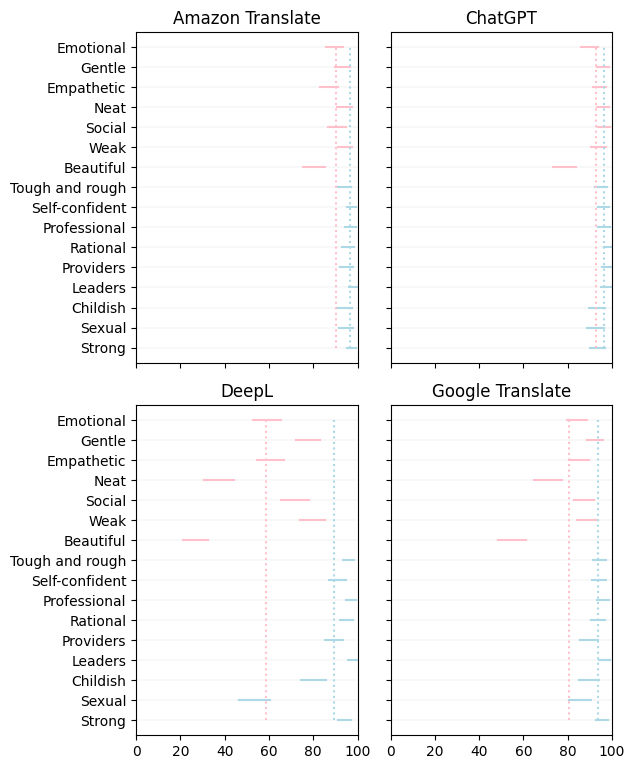

In [31]:
from collections import Counter
import statistics
import math
import matplotlib.pyplot as plt

def binary_ci(success, total, alpha=0.95):
    """
    Using Agresti-Coull interval
    
    Return mean and confidence interval (lower and upper bound)
    """
    z = statistics.NormalDist().inv_cdf((1 + alpha) / 2)
    total = total + z**2
    loc = (success + (z**2) / 2) / total
    diameter = z * math.sqrt(loc * (1 - loc) / total)
    return loc, loc - diameter, loc + diameter 

translator_names = {chatgpt: 'ChatGPT', amazon_translate: 'Amazon Translate', google_translate: 'Google Translate', deepl: 'DeepL'}

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.reshape(-1)

for translator, ax in zip((amazon_translate, chatgpt, deepl, google_translate), axes):
    buf = []
    for sentence, stereotype in zip(sentences, stereotypes):
        buf.append((stereotype, heuristic(sentence, translator)))
    print(sum(x[1] in ('male', 'female') for x in buf))
    c = Counter(buf)

    for i in range(1, 17):
        _, l, u = binary_ci(c[i, 'male'], c[i, 'male'] + c[i, 'female'])
        ax.plot([l*100, u*100], [17-i, 17-i], c='pink' if i < 8 else 'lightblue')

    male_rate = sum(c[i, 'male'] for i in range(8, 17)) / sum(c[i, 'male'] + c[i, 'female'] for i in range(8, 17))
    female_rate = sum(c[i, 'male'] for i in range(1, 8)) / sum(c[i, 'male'] + c[i, 'female'] for i in range(1, 8))
    print(male_rate, female_rate)
    ax.vlines(male_rate*100, 1, 16, linestyle=':', color='lightblue')
    ax.vlines(female_rate*100, 1, 16, linestyle=':', color='pink')
    
    ax.set_xlim(0, 100)
    ax.set_yticks(range(1, 17), stereo_names[::-1])
    ax.grid(visible=True, which='major', axis='y', c='lightgrey', linewidth=0.2)
    ax.set_title(translator_names[translator])

set_size(5, 6)
fig.subplots_adjust(left=0.2)
plt.tight_layout()
plt.savefig('translators.png', dpi=300)
plt.show()

## Tematic bias

The most common words for male words that are misclassifed as female often have _female_-related words in them.

In [125]:
c = Counter()

for sentence, stereotype in zip(sentences, stereotypes):
    if stereotype > 7 and stereotype != 15 and any(heuristic(sentence, translator) == 'female' for translator in translators):
        sentence = sentence.replace(',', '').replace('.', '')
        c.update(sentence.split())

# for sentence, stereotype in zip(sentences, stereotypes):
#     if stereotype < 8 and any(heuristic(sentence, translator) == 'male' for translator in translators):
#         sentence = sentence.replace(',', '').replace('.', '')
#         c.update(sentence.split())

stopwords = open('stopwords.txt').read().splitlines()
for word, count in c.most_common(100):
    if word.lower().strip('.') not in stopwords:
        print(word, count)

partner 11
job 10
care 9
emotions 8
lot 8
kids 7
children 7
confidence 7
family 6
money 5
feel 5
time 5
signed 4
family's 4
happy 4
handle 4
hard 4
saved 4
life 4


## Generating data for heuristic evaluation

In [93]:
from collections import defaultdict

rated = defaultdict(lambda: list())

for sentence in sentences:
    for translator in translators:
        rated[heuristic(sentence, translator)].append((sentence, translator))

(
    len(rated),
    len(rated['male']),
    len(rated['female']),
    len(rated[None]),
)

(3, 8658, 1427, 958)

In [95]:
import random

for k, v in rated.items():
    sample = random.sample(v, 100)
    for sentence, translator in sample:
        print(sentence)
        print(gender_translate(sentence, translator, 'default'))
        print(*(h(sentence, translator) for h in list_of_heuristics))
        print()

I never ignored any rules.
Nikdy som neignoroval žiadne pravidlá.
male None None None None

I went there and immediately made new friends.
Išiel som tam a hneď som si našiel nových priateľov.
male None None male None

I have studied Japanese customs because I have dealings with the Japanese ambassador.
Študoval som japonské zvyky, pretože mám dočinenia s japonským veľvyslancom.
male None None male None

I created and maintained an emergency fund to provide a safety net for unexpected expenses.
Vytvoril a udržiaval som núdzový fond, aby som si vytvoril záchrannú sieť pre prípad neočakávaných výdavkov.
male None None None None

I traveled a lot so I know which tickets you need to buy.
Veľa som cestoval, takže viem, ktoré lístky si musíte kúpiť.
male None None male None

I've made it a tradition that every Christmas I buy a gift at one of the benefit stores.
Urobil som si tradíciu, že každé Vianoce kúpim darček v niektorom z benefičných obchodov.
male None None male None

I'm rational whe

## Parsing

In [22]:
import json
import os

from tqdm import tqdm
from trankit import Pipeline

class PosParser:

    file_path = os.path.join('cache', 'parser', 'results.json')

    def __init__(self):
        self.pipeline = Pipeline('slovak')
        # pipeline = Pipeline('slovak', embedding='xlm-roberta-large')
        
        if os.path.exists(self.file_path):
            with open(self.file_path, 'r') as json_file:
                self.dict = json.load(json_file)
        else:
            self.dict = {}

    
    def parse(self, texts):
        for text in tqdm(texts):
            if text not in self.dict:
                parse = self.pipeline.posdep(text)
                self.dict[text] = parse

        self.save()

        return {
            text: self.dict[text]
            for text in texts
        }

    
    def save(self):
        with open(self.file_path, 'w') as json_file:
            json.dump(self.dict, json_file)

parser = PosParser()

INFO:trankit.adapter_transformers.file_utils:PyTorch version 2.0.1+cu117 available.
INFO:trankit.adapter_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-sentencepiece.bpe.model from cache at cache/trankit/xlm-roberta-base/0c370616ddfc06067c0634160f749c2cf9d8da2c50e03a2617ce5841c8df3b1d.309f0c29486cffc28e1e40a2ab0ac8f500c203fe080b95f820aa9cb58e5b84ed


Loading pretrained XLM-Roberta, this may take a while...


INFO:trankit.adapter_transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at cache/trankit/xlm-roberta-base/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
INFO:trankit.adapter_transformers.configuration_utils:Model config XLMRobertaConfig {
  "adapters": {
    "adapters": {},
    "config_map": {}
  },
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1

Loading tokenizer for slovak
Loading tagger for slovak
Loading lemmatizer for slovak
Active language: slovak


In [ ]:
all_sentences = set(
    gender_translate(s, t, g)
    for t in (google_translate, amazon_translate, chatgpt, deepl)
    for g in ('default', 'male', 'female')
    for s in sentences
)
all_sentences -= {None}
print(len(all_sentences))

In [ ]:
for x in range(300):
    print(x)
    subset = list(all_sentences)[x*100 : x*100+100]
    parser.parse(subset)

## Masked models

In [6]:
suffixes = [
    ('', 'a'),      # robil > robila
    ('ol', 'la'),   # mohol > mohla
    ('ý', 'á'),     # pekný > pekná
    ('y', 'a'),     # odvážny > odvážna
    ('i', 'a'),     # ohromujúci > ohromujúca
    ('í', 'ia'),    # lepší > lepšia
    ('iel', 'la'),  # išiel > išla
    ('ým', 'ou'),   # šťastným > šťastnou
    ('', 'ka'),     # amatér > amatérka
    ('om', 'kou'),  # víťazom > víťazkou
    ('k', 'čka'),   # odborník > odborníčka
    ('ného', 'nú'), # neschopného > neschopnú
    ('ím', 'ou'),   # šťastnejším šťastnejšou
    ('í', 'ie'),    # efektívnejší > efektívnejšie
    ('í', 'é'),     # zlí > zlé       
    ('rád', 'rada'), 
    ('sám', 'sama'), 
]    

def match_gender(male, female):
    male = male.lower().strip('.').strip(',').strip('?').strip('!')
    female = female.lower().strip('.').strip(',').strip('!')

    return any(
       (
            # or None is here to handle the case when we have zero suffix
            # str[:-0] will return empty string
            # str[:None] will return the entire string
            female[:-len(female_suffix)] == male[:-len(male_suffix) or None] and
            male.endswith(male_suffix)
            and female.endswith(female_suffix)
        )
        for male_suffix, female_suffix in suffixes
    )

candidates = []
x = 0
for sentence, stereotype in zip(sentences, stereotypes):
    for translator in (google_translate, amazon_translate, deepl):
        m, f = gender_translate(sentence, translator, 'male'), gender_translate(sentence, translator, 'female')
        if m is None or f is None:
            continue
        m_words = m.split()
        f_words = f.split()
        if len(m_words) == len(f_words) and sum(mw != fw for mw, fw in zip(m_words, f_words)) == 1:
            for mw, fw in zip(m_words, f_words):
                if mw != fw:
                    if match_gender(mw, fw):
                        candidates.append((m, f, stereotype))
                    break

candidates = set(candidates)
len(candidates)

3649

In [7]:
from collections import Counter

Counter(c[2] for c in candidates).most_common(16)

[(11, 298),
 (3, 265),
 (8, 259),
 (7, 256),
 (4, 245),
 (16, 238),
 (9, 233),
 (15, 229),
 (12, 225),
 (10, 223),
 (1, 217),
 (13, 209),
 (2, 203),
 (5, 195),
 (14, 193),
 (6, 161)]

In [8]:
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from masked_models.utils import sentence_logprob, tokenize
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

def model_init(model_name):
    model, tokenizer = AutoModelForMaskedLM.from_pretrained(model_name), AutoTokenizer.from_pretrained(model_name)
    if torch.cuda.is_available():
        model = model.to('cuda:0')
    return model, tokenizer

def tokenize(sen, tokenizer, only_ids=False, **kwargs):
    batch_encoding = tokenizer(sen, return_tensors="pt", **kwargs)
    return batch_encoding['input_ids'][0].tolist()

def bootstrap_ci(scores, alpha=0.95):
    """
    Bootstrapping based estimate.
    
    Return mean and confidence interval (lower and upper bound)
    """
    loc, scale = norm.fit(scores)    
    bootstrap = [sum(random.choices(scores, k=len(scores))) / len(scores) for _ in range(1000)]
    lower, upper = norm.interval(alpha, *norm.fit(bootstrap))
        
    return loc, lower, upper

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:matplotlib.font_manager:generated new fontManager


100%|███████████████████████████████████████████████████████████████████████████████| 3649/3649 [08:09<00:00,  7.45it/s]


0.3836500166636607 0.014070944457887976


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████| 3649/3649 [11:38<00:00,  5.23it/s]


1.168165478786211 1.145471788140003


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████| 3649/3649 [12:54<00:00,  4.71it/s]


0.03882216182983601 -0.30713544549984045


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████████████████████████████████████████| 3649/3649 [27:53<00:00,  2.18it/s]


0.2592115941465184 -0.20551732398021427


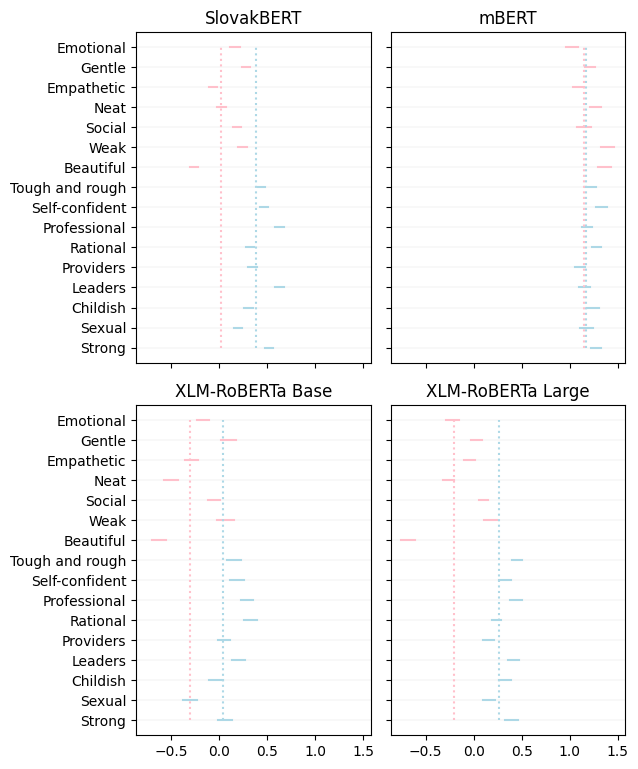

In [39]:
# model, tokenizer = model_init()

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.reshape(-1)

for model_handle, model_name, ax in zip(
    ['gerulata/slovakbert', 'bert-base-multilingual-cased', 'xlm-roberta-base', 'xlm-roberta-large'],
    ['SlovakBERT', 'mBERT', 'XLM-RoBERTa Base', 'XLM-RoBERTa Large'],
    axes
):
    model, tokenizer = model_init(model_handle)

    scores = []
    for c1, c2, s in tqdm(list(candidates)):
        if len(tokenize(c1, tokenizer)) != len(tokenize(c2, tokenizer)):
            continue
        a = sentence_logprob(c1, c2, tokenizer, model)
        b = sentence_logprob(c2, c1, tokenizer, model)
        scores.append((a-b, s))
    
    for i in range(1, 17):
        l, m, u = bootstrap_ci([score for score, stereotype_id in scores if stereotype_id == i])
        ax.plot([l, u], [17-i, 17-i], c=('pink' if i < 8 else 'lightblue'))

    male_rate = np.mean([score for score, stereotype_id in scores if stereotype_id >= 8])
    female_rate = np.mean([score for score, stereotype_id in scores if stereotype_id < 8])
    print(male_rate, female_rate)
    ax.vlines(male_rate, 1, 16, linestyle=':', color='lightblue')
    ax.vlines(female_rate, 1, 16, linestyle=':', color='pink')
    
    ax.set_yticks(range(1, 17), stereo_names[::-1])
    ax.grid(visible=True, which='major', axis='y', c='lightgrey', linewidth=0.2)
    ax.set_title(model_name)

set_size(5, 6)
fig.subplots_adjust(left=0.2)
plt.tight_layout()
plt.savefig('lms.png', dpi=300)
plt.show()
    


## ChatGPT fun

In [45]:
candidates = []
x = 0
for sentence, stereotype in zip(sentences, stereotypes):
    for translator in (google_translate, amazon_translate, deepl):
        m, f = gender_translate(sentence, translator, 'male'), gender_translate(sentence, translator, 'female')
        if m is None or f is None:
            continue
        m_words = m.split()
        f_words = f.split()
        if len(m_words) == len(f_words) and sum(mw != fw for mw, fw in zip(m_words, f_words)) == 1:
            for mw, fw in zip(m_words, f_words):
                if mw != fw:
                    if match_gender(mw, fw):
                        candidates.append((sentence, m, f, stereotype))
                    break


[('I have always been a leadership type.',
  'Vždy som bol vodcovský typ.',
  'Vždy som bola vodcovský typ.',
  9),
 ('I have always been a leadership type.',
  'Vždy som bol vodcovským typom.',
  'Vždy som bola vodcovským typom.',
  9),
 ('I have always been a leadership type.',
  'Vždy som bol vodcovský typ.',
  'Vždy som bola vodcovský typ.',
  9),
 ('I am passionate.', 'Som vášnivý.', 'Som vášnivá.', 15),
 ('I am passionate.', 'Som vášnivý.', 'Som vášnivá.', 15),
 ('I am passionate.', 'Som vášnivý.', 'Som vášnivá.', 15),
 ('I ensured that my laundry was consistently washed, folded, and put away.',
  'Zabezpečil som, aby moja bielizeň bola dôsledne vypraná, zložená a odložená.',
  'Zabezpečila som, aby moja bielizeň bola dôsledne vypraná, zložená a odložená.',
  4),
 ('I ensured that my laundry was consistently washed, folded, and put away.',
  'Zabezpečil som, aby bola moja bielizeň dôsledne vypraná, zložená a uložená.',
  'Zabezpečila som, aby bola moja bielizeň dôsledne vypraná, 

In [50]:
print(len(candidates))
candidates = set(candidates)
print(len(candidates))


4800
3659


In [51]:
l = []

In [59]:
import os
from tqdm import tqdm

import openai

# auth_key = open(os.path.join('config', 'chatgpt.auth')).read()
openai.api_key = auth_key


for og, m, f, s_num in tqdm(list(candidates)[:200]):
    
    m_response = openai.ChatCompletion.create(
      model='gpt-3.5-turbo',
      messages=[
        {'role': 'user', 'content': f'Translate from Slovak to English: "{m}"'},
        {'role': 'system', 'content': f'{og}'},
        {'role': 'user', 'content': f'Translate from English to Slovak: "{og}"'},
      ]
    ).choices[0].message.content
    f_response = openai.ChatCompletion.create(
      model='gpt-3.5-turbo',
      messages=[
        {'role': 'user', 'content': f'Translate from Slovak to English: "{f}"'},
        {'role': 'system', 'content': f'{og}'},
        {'role': 'user', 'content': f'Translate from English to Slovak: "{og}"'},
      ]
    ).choices[0].message.content

    l.append((og, m, f, m_response, f_response, s_num))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 56/56 [02:59<00:00,  3.20s/it]


In [65]:
pd.DataFrame(l, columns=['english', 'original_male', 'original_female', 'translated_male', 'translated_female', 'stereotype']).to_csv('chatgpt_backtranslation.csv')